In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import torch.nn as nn

from torch import utils
from torch import optim
from torch import device
from torch import inference_mode

import tqdm

from timeit import default_timer as timer
from tqdm.auto import tqdm

from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy
from torchvision.transforms.v2 import (
    ConvertImageDtype,
    Normalize,
    Resize,
    CenterCrop,
    ToTensor,
    ToImage,
    Compose
)

import medmnist
from medmnist import INFO, Evaluator

In [2]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")
for i in range(num_gpus):
    print(f"{i+1}. GPU {i}: {torch.cuda.get_device_name(i)}")

device = 0  # "Select the index of the GPU you wish to use"
torch.cuda.set_device(device)
print(f"GPU selection: {torch.cuda.get_device_name(device)}")

device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device1}")

Number of GPUs available: 1
1. GPU 0: NVIDIA GeForce MX110
GPU selection: NVIDIA GeForce MX110
Using device: cuda:0


In [3]:
transformacion = Compose([
    ToTensor(), 
    Normalize(mean=[0.5], std=[0.5])
    ])

/home/pablo/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
data_flag = "pathmnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info["python_class"])

# Load the training and testing datasets
train_data = DataClass(split="train", transform=transformacion, download=True)
val_data = DataClass(split="val", transform=transformacion, download=True)
test_data = DataClass(split="test", transform=transformacion, download=True)

100%|██████████| 205615438/205615438 [00:20<00:00, 10059790.46it/s]


Using downloaded and verified file: /home/pablo/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/pablo/.medmnist/pathmnist.npz


In [5]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [6]:
# Number of image channels
n_channels = info["n_channels"]
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info["label"])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info["label"]
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].


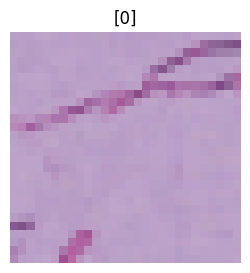

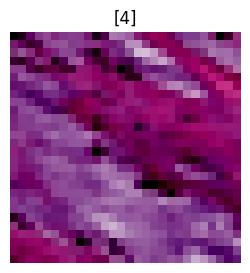

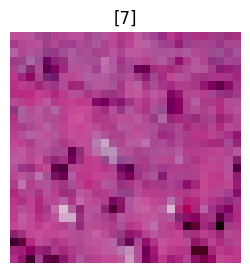

In [7]:
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False)

In [8]:
# change data into dataloader form
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# check dataloader
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd88dd53cd0>, <torch.utils.data.dataloader.DataLoader object at 0x7fd88dd53490>)
Length of train dataloader: 704 batches of 128
Length of test dataloader: 57 batches of 128
Length of val dataloader: 79 batches of 128
